# Identifying Different Types of Cell Nuclei in Cancer Samples using 2 Different ConvNets

### 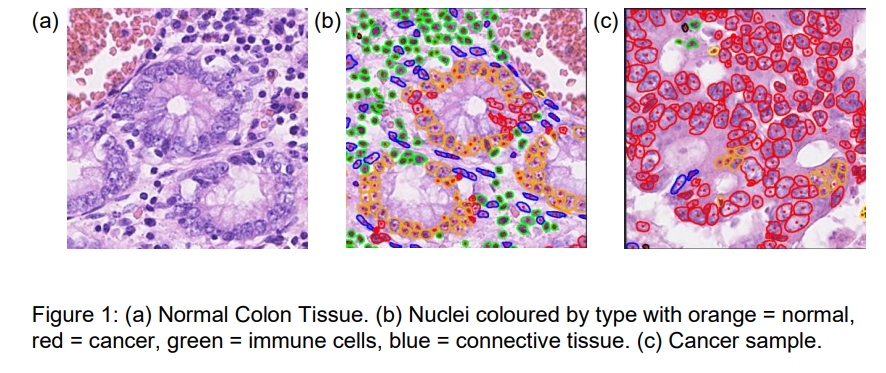

# Imports

In [21]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import gc
from itertools import chain 
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
# !pip install ray

from functools import partial
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [22]:
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torchvision import models

E0326 17:46:21.533103645   23016 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


^C
ERROR: Operation cancelled by user


In [23]:
# Used this tutorial for help with visualizatons : https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy/notebook

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Plotting a Single Image

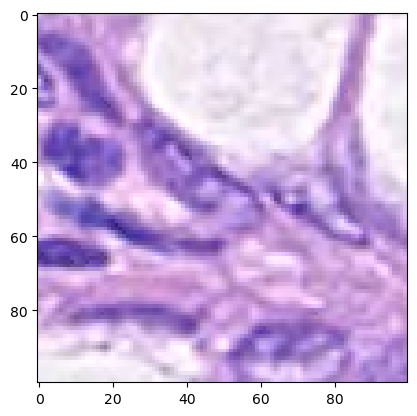

In [25]:
plt.imshow(io.imread('/kaggle/input/deep-learning-for-msc-2022-23/train/1.png'))

In [26]:
def show_cell(image):
    """Show image with landmarks"""
    plt.imshow(image)
def show_cells(image,label):
    """Show image with landmarks"""
    plt.imshow(image.permute(1, 2, 0).numpy())

## Reading Training Data Into a Dataframe

In [27]:
data = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/train.csv")
data = data.sample(frac=1).reset_index(drop=True)
data

,Filename,Label
0,2918.png,1
1,3235.png,1
2,3425.png,1
3,5316.png,3
4,914.png,1
...,...,...
7555,7206.png,3
7556,80.png,0
7557,919.png,1
7558,4817.png,2


## Splitting Data Into Training and Validation Sets

In [28]:
training_data = data.head(6000)
validation_data = data.tail(1560)


In [29]:
del data
gc.collect()

245

## Creating Cell Dataset Class

In [30]:
class CellsDataset(Dataset):
    """Cells dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cells_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cells_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.cells_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.cells_frame.iloc[idx, 1]
#         sample = {'image': image, 'label': label}

        if self.transform is not None:
            image = self.transform(image)

        return image,label

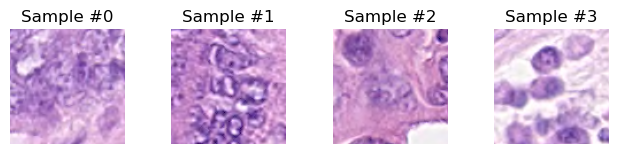

In [31]:
cells_dataset = CellsDataset(df=training_data,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train')

fig = plt.figure()

for i in range(len(cells_dataset)):
    image,label = cells_dataset[i]

    #print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_cell(image)

    if i == 3:
        plt.show()
        break

## Visualize Transforms

The transforms that I elected to use were CenterCrop, RandomRotation, and Normalization. CenterCrop was used with the understanding that only the nuclei in the center of each image were necessary for learning. RandomRotation was added to introduce some noise to the data. Conversion to a PIL Image was necessary for the CenterCrop transformation to work without needing to create a custom class. 

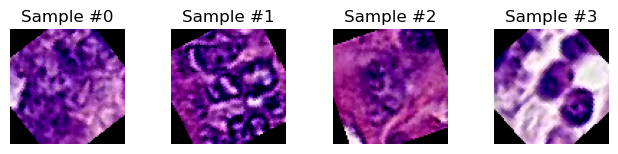

In [32]:
# transform data to center crop on nucleus and normalize the data
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.CenterCrop(80),
                                transforms.RandomRotation(degrees=180),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ])

trained_dataset = CellsDataset(df = training_data,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                           transform= transform)
validation_dataset = CellsDataset(df = validation_data,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                           transform=transform)

for i in range(len(trained_dataset)):
    image,label = trained_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_cells(image,label)

    if i == 3:
        plt.show()
        break



In [33]:
train_loader = DataLoader(trained_dataset, batch_size=50)
validation_loader = DataLoader(validation_dataset)

# Model 1 - CNN

My CNN Model has two convolutional layers both with max pooling with a kernel of size 2X2. Each convulational layer also has a ReLU activation layer to introduce non-linearity. Finally, there are two fully connected layers with a dropout layer inbetween to try to avoid overfitting.

In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 20, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 512, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(512 * 12 * 12, 1028)
        self.fc1 = nn.Linear(512 * 20 * 20, 1028)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1028, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Train + Validate and Visualize Loss, Accuracy, Confusion Matrix

In [35]:
import datetime
epoch_print_gap = 1
from sklearn.metrics import confusion_matrix

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, test_loader):
    model = model.to(device)
    
    #for loss,accuracy charts
    iteration_list = []
    loss_list = []
    accuracy_list = []
    
    #for confusion matrix
    predictions_list = []
    labels_list = []
    
    
    count = 0
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            count += 1
            
            if not (count % 50):
                loss_list.append(loss.item())
                iteration_list.append(count)
                
                model.eval()
                model = model.to(device)
                test_loss = 0
                total = 0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(device), target.to(device)
                        labels_list.append(target.item())
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
                        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                        predictions_list.append(pred.item())
                        correct += pred.eq(target.view_as(pred)).sum().item()
                        total += len(target)

                accuracy = correct * 100 / total
                accuracy_list.append(accuracy)
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
    
    # plot loss
    plt.plot(iteration_list, loss_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Loss")
    plt.title("Iterations vs Loss")
    plt.show()
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
    #plot accuracy
    plt.plot(iteration_list, accuracy_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Accuracy")
    plt.title("Iterations vs Accuracy")
    plt.show()
    
    # confusion matrix
    cm = confusion_matrix(predictions_list, labels_list)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()


2023-03-26 17:48:33.075002 Epoch 1, Training loss 94.77155095338821
2023-03-26 17:49:41.552492 Epoch 2, Training loss 59.487230092287064
2023-03-26 17:51:03.148013 Epoch 3, Training loss 53.17033389210701
2023-03-26 17:52:12.551040 Epoch 4, Training loss 49.54079772531986
2023-03-26 17:53:33.966925 Epoch 5, Training loss 45.08564029633999
2023-03-26 17:54:43.053038 Epoch 6, Training loss 42.419759690761566
2023-03-26 17:55:52.230548 Epoch 7, Training loss 41.80956068634987
2023-03-26 17:57:11.744594 Epoch 8, Training loss 38.55060729384422
2023-03-26 17:58:19.948997 Epoch 9, Training loss 35.58201303333044
2023-03-26 17:59:39.564980 Epoch 10, Training loss 34.528712287545204
2023-03-26 18:00:47.540396 Epoch 11, Training loss 33.30383878946304
2023-03-26 18:01:55.432088 Epoch 12, Training loss 32.19517459720373
2023-03-26 18:03:15.144169 Epoch 13, Training loss 30.508201830089092
2023-03-26 18:04:23.222866 Epoch 14, Training loss 29.404435984790325
2023-03-26 18:05:43.927853 Epoch 15, T

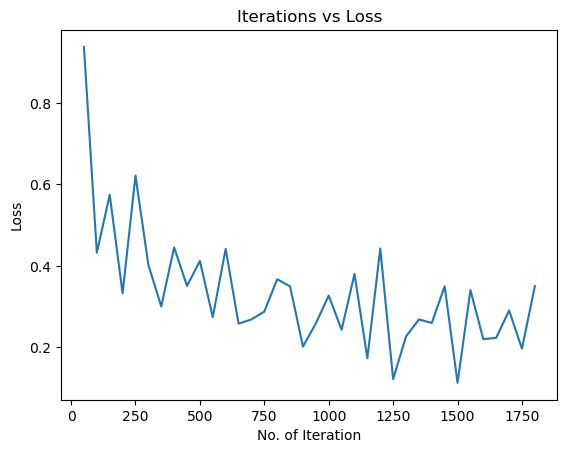


Test set: Average loss: 388.0065, Accuracy: 1410/1560 (90%)



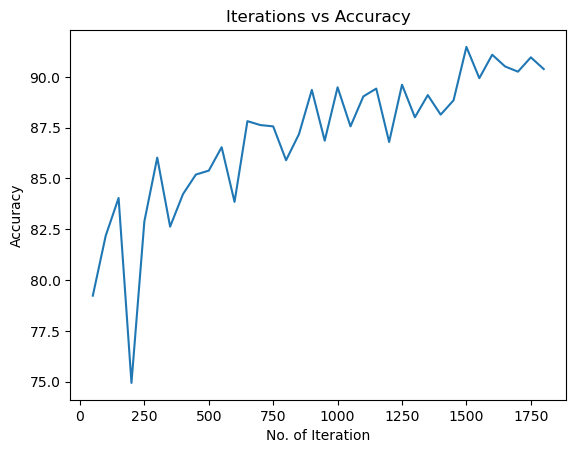

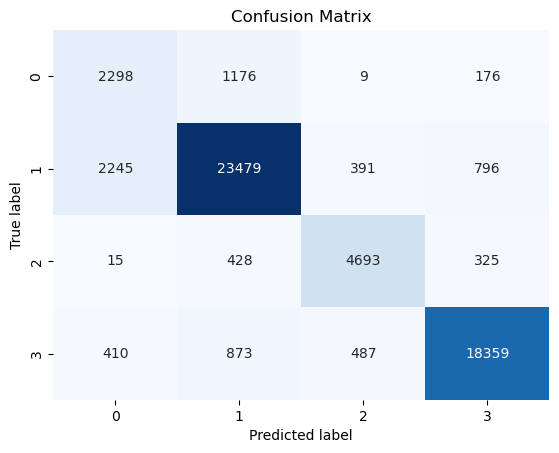

In [37]:
opt_model = CNNModel()
optimizer = optim.SGD(opt_model.parameters(), lr=0.01, momentum=0.9)
training_loop(
    n_epochs = 15, 
    optimizer = optimizer,
    model = opt_model, 
    device = device,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    test_loader = validation_loader
)


The Loss and Accuracy curves show that the model gradually starts learning less and less around 1500 iterations (~13 epochs) so 15 epochs is ideal for maximizing the CNN without overfitting. The confusion matrix shows that the model has the most difficulty identifying class '0' images so I tried to improve this by adding more noise to the dataset via a RandomRotation transformation.  

Even with hyperparamter tuning, I was unable to reach an accuracy rate higher than ~90/91% with my custom CNN. 

# Ray Tune Optimization

In [38]:
# wrap data_loaders into a function
def data_loaders(batch_size):
    
    trained_dataset = CellsDataset(df = training_data,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                           transform=transform)
    validation_dataset = CellsDataset(df = validation_data,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                           transform=transform)
    train_loader = DataLoader(trained_dataset, batch_size=batch_size)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
    return train_loader, validation_loader
    

In [39]:
# ray tune training function combining validation. Repurposed version of the 
# training loop above
def train_model(config):
    # Initialize model, optimizer, loss_fn, and data loaders
    
    model = CNNModel()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    #get  train, validation loaders from wrapper function    
    train_loader, validation_loader = data_loaders(config['batch_size'])
    
   
    
    
    optimizer =  optim.SGD(model.parameters(),lr=config["lr"],momentum=config["momentum"])
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    for i in range(config["num_epochs"]):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        # Validation loss
                
        model.eval()
        model = model.to(device)
        val_loss = 0
        correct = 0
        steps = 0
        total = 0
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                steps += 1
        
                total += target.size(0)
        
        # Log metrics for Ray Tune
        tune.report(loss=(val_loss / steps), accuracy=correct / total)
            

    print("Accuracy:")
    print(correct/len(validation_loader.dataset))
    print("finished training")

In [40]:
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32,64,128]),
    "momentum":tune.choice([0.5,0.75,0.90]),
    "num_epochs": 15
}


# Set up Ray Tune scheduler
scheduler = tune.schedulers.ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)

# Run hyperparameter search with Ray Tune
analysis = tune.run(
    partial(train_model),
    resources_per_trial={"cpu": 2, "gpu": 2},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=tune.CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"], 
                                       max_progress_rows=10, 
                                       print_intermediate_tables=False,
                                       max_report_frequency=600))

# Get best hyperparameters
best_trial = analysis.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))


# Train final model with best hyperparameters

== Status ==
Current time: 2023-03-26 18:09:08 (running for 00:00:00.27)
Memory usage on this node: 4.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2023-03-26_18-09-08
Number of trials: 10/10 (9 PENDING, 1 RUNNING)




Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_4d892_00000,0.0884615,2023-03-26_18-17-37,True,,2bf00d5f8695432f82a728e7c3233f77,dbb1f9b1dc5e,10,nan,172.19.2.2,37036,502.798,48.2055,502.798,1679854657,0,,10,4d892_00000,0.00559425
train_model_4d892_00001,0.863462,2023-03-26_18-26-09,True,,afa261ab0806450f88988b4b8b6effa2,dbb1f9b1dc5e,10,23.1194,172.19.2.2,39858,506.169,49.6625,506.169,1679855169,0,,10,4d892_00001,0.004843
train_model_4d892_00002,0.866026,2023-03-26_18-34-39,True,,c6406eb71ca94b7a9f6fb0e16de7225e,dbb1f9b1dc5e,10,22.8521,172.19.2.2,42768,503.443,48.0332,503.443,1679855679,0,,10,4d892_00002,0.00538421
train_model_4d892_00003,0.833333,2023-03-26_18-48-06,True,,b7acdc171f79439fbfaa5703cc3c83d9,dbb1f9b1dc5e,10,13.613,172.19.2.2,45597,801.365,78.8128,801.365,1679856486,0,,10,4d892_00003,0.00542593
train_model_4d892_00004,0.858974,2023-03-26_19-01-37,True,,c4bc71e26bec417a8654a2d5c23b0dc5,dbb1f9b1dc5e,10,12.1812,172.19.2.2,51012,804.29,79.7396,804.29,1679857297,0,,10,4d892_00004,0.00559616
train_model_4d892_00005,0.775641,2023-03-26_19-02-50,True,,4b9e5671aac74a028c98446cf834b5a5,dbb1f9b1dc5e,1,43.8659,172.19.2.2,56448,66.8526,66.8526,66.8526,1679857370,0,,1,4d892_00005,0.0056088
train_model_4d892_00006,0.664744,2023-03-26_19-04-03,True,,fe93a6fd63ea4389ba914cea85aeee1e,dbb1f9b1dc5e,1,59.5021,172.19.2.2,56795,67.186,67.186,67.186,1679857443,0,,1,4d892_00006,0.00565958
train_model_4d892_00007,0.701923,2023-03-26_19-06-58,True,,aaf57fbf46304e0eb9652689e47502fd,dbb1f9b1dc5e,2,33.4503,172.19.2.2,57135,167.557,78.8342,167.557,1679857618,0,,2,4d892_00007,0.00535178
train_model_4d892_00008,0.61859,2023-03-26_19-08-05,True,,5f19843a107a4e729bb7367f5bd46926,dbb1f9b1dc5e,1,110.46,172.19.2.2,58268,61.394,61.394,61.394,1679857685,0,,1,4d892_00008,0.00579453
train_model_4d892_00009,0.588462,2023-03-26_19-09-13,True,,7e68af5dfa7f40f3825fb908394a34c7,dbb1f9b1dc5e,1,130.426,172.19.2.2,58490,61.4428,61.4428,61.4428,1679857753,0,,1,4d892_00009,0.00521016


== Status ==
Current time: 2023-03-26 18:19:10 (running for 00:10:02.06)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -52.59161354064941
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2023-03-26_18-09-08
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)


== Status ==
Current time: 2023-03-26 18:29:14 (running for 00:20:05.44)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -24.61418800354004 | Iter 4.000: -30.710018501281738 | Iter 2.000: -37.47424104690552 | Iter 1.000: -47.32558982849121
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2023-03-26_18-09-08
Number of trials: 10/10 (7 PENDING, 1 RUNNI

2023-03-26 19:09:13,499	INFO tune.py:763 -- Total run time: 3604.90 seconds (3604.75 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 19:09:13 (running for 01:00:04.76)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -19.177147519831756 | Iter 4.000: -22.66449106586223 | Iter 2.000: -31.001858825683595 | Iter 1.000: -43.86594669342041
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2023-03-26_18-09-08
Number of trials: 10/10 (10 TERMINATED)
+-------------------------+------------+------------------+--------------+-------------+------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |          lr |   momentum |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+-------------+------------+----------+------------+----------------------|
| train_model_4d892_00000 | TERMINATED | 172.

Using ray tune, I was able to get the lowest validation loss with 'Best trial config' listed above. However, through trial and error, I found that my model received higher accuracy (~91%) as compared to the ray tune configuration even though the validation loss was always greater. As such, I opted to use momentum: 0.9, lr: 0.01, and a batch size of 50 instead.

## Captum

Using one image to observe how the model is working.

In [41]:
opt_model = opt_model.eval()
input_image,image_label = trained_dataset[1]
input_image = input_image.to(device)
input_image = input_image.unsqueeze(0)
output_model1 = opt_model(input_image)
output_model1 = F.softmax(output_model1, dim=1)
prediction_score, pred_label_idx = torch.topk(output_model1, 1)

## Gradient Based Attribution

We can see that the darkest areas of the original image are highlighted in integrated gradients visualization.

In [42]:
integrated_gradients = IntegratedGradients(opt_model)
attributions_ig = integrated_gradients.attribute(input_image, target=pred_label_idx, n_steps=200)

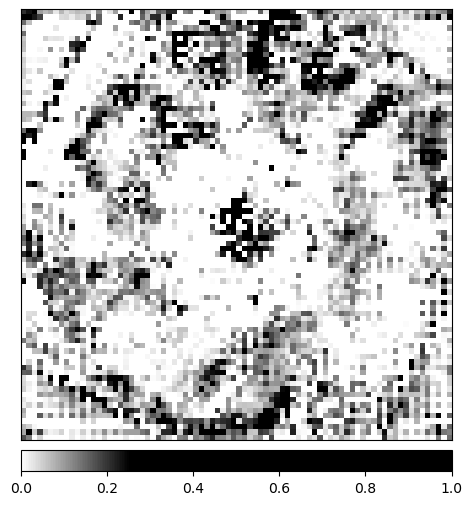

In [43]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

However, after adding some gaussian noise, it seems that only the very center of the image (even after CenterCropping and using other transformations) is used in the prediction of the model. 

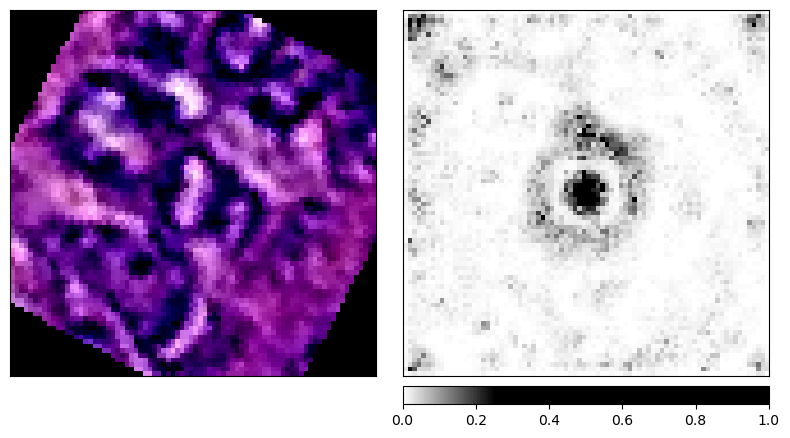

In [44]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input_image, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Occlusion Based Attribution

Visualizing the occlusion based attribution shows again that the center of the image is most critical for the model prediction of class while some of the surrounding darker areas of the image also impact the prediction. 

In [45]:
occlusion = Occlusion(opt_model)

attributions_occ = occlusion.attribute(input_image,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

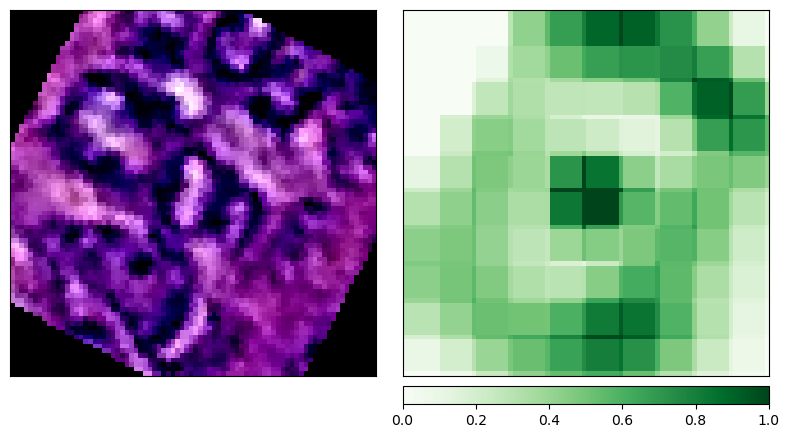

In [46]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

# Submission CSV

In [50]:
test_files = os.listdir("/kaggle/input/deep-learning-for-msc-2022-23/test")
test_df = pd.DataFrame({'Filename':test_files, 'Labels':""})
test_df


,Filename,Labels
0,14127.png,
1,11396.png,
2,14260.png,
3,12329.png,
4,13412.png,
...,...,...
5036,13785.png,
5037,13283.png,
5038,14735.png,
5039,12060.png,


In [51]:
test_dataset = CellsDataset(df = test_df,
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test',
                                           transform=transform)

In [52]:
test_loader = DataLoader(test_dataset)

In [53]:
def output_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)

    labels = []
    with torch.no_grad():
        for data,target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).item()
            labels.append(pred)
            
            # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()
    output_df = pd.DataFrame({"Filename":test_files, "Label":labels})
    return output_df
    

In [ ]:
submission_df = output_loop(model=opt_model, device=device, test_loader=test_loader)
submission_df


In [ ]:
submission_df.to_csv('/kaggle/working/submission.csv',index=False)

# Model 2

## Load Pretrained Model and Modify

The ResNet18 model below is pretrained on Imagenet. The final fully connected layer is modified to output 4 to match the number of the classes in our cells dataset. 

In [47]:
model2 = models.resnet18(pretrained=True)
num_ftrs = model2.fc.in_features

#modify the fully connected layer to output 4 to match the dataset
model2.fc = nn.Linear(num_ftrs, 4)
model2 = model2.to(device)

## Train Model 2

The same training function as used for Model 1 with minor adjustments. The modified ImageNet trained model is now trained and validated on the data. 

In [48]:
import datetime
epoch_print_gap = 1
from sklearn.metrics import confusion_matrix

def training_loop2(n_epochs, optimizer, model, device, loss_fn, train_loader, test_loader):
    model = model.to(device)

    #for loss,accuracy charts
    iteration_list = []
    loss_list = []
    accuracy_list = []
    
    #for confusion matrix
    predictions_list = []
    labels_list = []
    
    
    count = 0
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            model.train()
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            count += 1
#             print(outputs)
#             print(loss.item())
            if not (count % 50):
                loss_list.append(loss.item())
                iteration_list.append(count)
#                 print(loss_list)
                
                model.eval()
                model = model.to(device)
                test_loss = 0
                total = 0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(device), target.to(device)
                        labels_list.append(target.item())
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
                        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                        predictions_list.append(pred.item())
                        correct += pred.eq(target.view_as(pred)).sum().item()
                        total += len(target)

                accuracy = correct * 100 / total
                accuracy_list.append(accuracy)
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
    
    # plot loss
    plt.plot(iteration_list, loss_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Loss")
    plt.title("Iterations vs Loss")
    plt.show()
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
    #plot accuracy
    plt.plot(iteration_list, accuracy_list)
    plt.xlabel("No. of Iteration")
    plt.ylabel("Accuracy")
    plt.title("Iterations vs Accuracy")
    plt.show()
    
    # confusion matrix
    cm = confusion_matrix(predictions_list, labels_list)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()


2023-03-26 19:12:38.316234 Epoch 1, Training loss 54.969449400901794
2023-03-26 19:13:35.031898 Epoch 2, Training loss 30.436807073652744
2023-03-26 19:14:44.267299 Epoch 3, Training loss 22.75424613058567
2023-03-26 19:15:40.965819 Epoch 4, Training loss 18.801539573818445
2023-03-26 19:16:50.336450 Epoch 5, Training loss 16.33737773820758
2023-03-26 19:17:46.864960 Epoch 6, Training loss 14.110115183982998
2023-03-26 19:18:42.151186 Epoch 7, Training loss 13.749002839438617
2023-03-26 19:19:52.113277 Epoch 8, Training loss 10.516163192689419
2023-03-26 19:20:47.612341 Epoch 9, Training loss 10.564330930355936
2023-03-26 19:21:56.821647 Epoch 10, Training loss 9.583518226398155
2023-03-26 19:22:52.688132 Epoch 11, Training loss 8.795712707564235
2023-03-26 19:23:47.749432 Epoch 12, Training loss 7.614522653166205
2023-03-26 19:24:57.642257 Epoch 13, Training loss 6.7260105481836945
2023-03-26 19:25:53.211201 Epoch 14, Training loss 7.100704955402762
2023-03-26 19:27:02.402171 Epoch 15

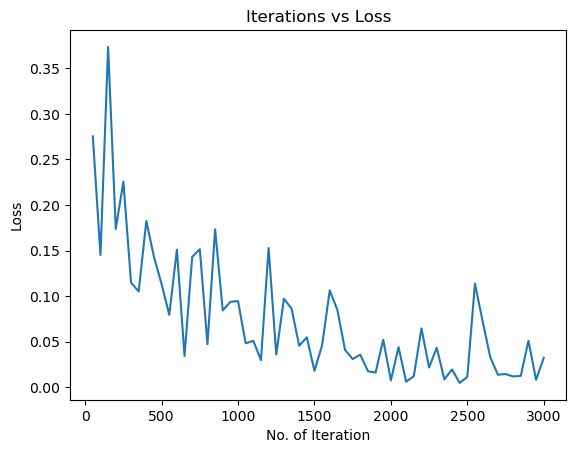


Test set: Average loss: 132.3978, Accuracy: 1525/1560 (98%)



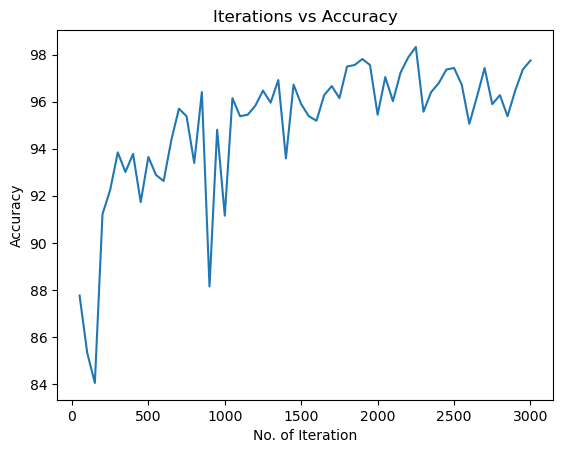

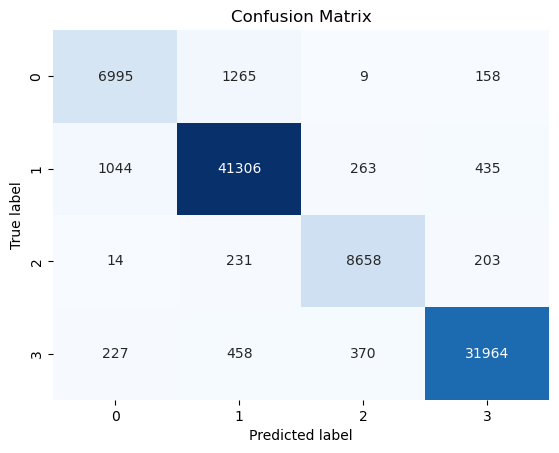

In [49]:
model2 = models.resnet18(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 4)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
training_loop2(
    n_epochs = 25, 
    optimizer = optimizer2,
    model = model2, 
    device = device,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    test_loader = validation_loader
)


Analysing the Loss and Accuracy curves, the model does not improve much after ~15 epochs. The model performs quite well with ~98% accuracy and low loss. The confusion matrix also shows that the model is extremely effective for classes '1' and '3' while it does not work as well for class class '0'. Overall, the ImageNet pretrained model has performed significantly better than my custom CNN. 

## Ray Tune

In [56]:
# ray tune training function combining 
def train_model2(config):
    # Initialize model, optimizer, loss_fn, and data loaders
    
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features

    #modify the fully connected layer to output 4 to match the dataset
    model.fc = nn.Linear(num_ftrs, 4)

    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    #get  train, validation loaders from wrapper function    
    train_loader, validation_loader = data_loaders(config['batch_size'])
    
   
    
    
    optimizer =  optim.SGD(model.parameters(),lr=config["lr"],momentum=config["momentum"])
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    for i in range(config["num_epochs"]):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        # Validation loss
                
        model.eval()
        model = model.to(device)
        val_loss = 0
        correct = 0
        steps = 0
        total = 0
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                steps += 1
        
                total += target.size(0)
        
        # Log metrics for Ray Tune
        tune.report(loss=(val_loss / steps), accuracy=correct / total)
            

    print("Accuracy:")
    print(correct/len(validation_loader.dataset))
    print("finished training")

In [57]:
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32,64,128]),
    "momentum":tune.choice([0.5,0.75,0.90]),
    "num_epochs": 15
}


# Set up Ray Tune scheduler
scheduler = tune.schedulers.ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)

# Run hyperparameter search with Ray Tune
analysis = tune.run(
    partial(train_model2),
    resources_per_trial={"cpu": 2, "gpu": 2},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=tune.CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"], 
                                       max_progress_rows=10, 
                                       print_intermediate_tables=False,
                                       max_report_frequency=600))

# Get best hyperparameters
best_trial = analysis.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))




== Status ==
Current time: 2023-03-26 19:53:33 (running for 00:00:00.25)
Memory usage on this node: 4.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-26_19-53-33
Number of trials: 10/10 (9 PENDING, 1 RUNNING)




(func pid=60751) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=60751)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=60751) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=60751)   warnings.warn(msg)


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model2_e36b5_00000,0.0884615,2023-03-26_19-59-41,True,,b4be26bc488d48a5a7651fd096acf99b,dbb1f9b1dc5e,10,nan,172.19.2.2,60751,362.435,34.475,362.435,1679860781,0,,10,e36b5_00000,0.00570154
train_model2_e36b5_00001,0.844872,2023-03-26_20-00-25,True,,13b7b58a08b7427a8cb66878c293d55e,dbb1f9b1dc5e,1,48.2385,172.19.2.2,65830,36.8112,36.8112,36.8112,1679860825,0,,1,e36b5_00001,0.00546432
train_model2_e36b5_00002,0.361538,2023-03-26_20-01-14,True,,a08ebd4b9e044406b6dfcd8fa1f65fa8,dbb1f9b1dc5e,1,438338,172.19.2.2,66034,43.9254,43.9254,43.9254,1679860874,0,,1,e36b5_00002,0.00527263
train_model2_e36b5_00003,0.494872,2023-03-26_20-02-08,True,,df2416bd88fe4e8089f6d7401e73276f,dbb1f9b1dc5e,1,130.613,172.19.2.2,66597,46.232,46.232,46.232,1679860928,0,,1,e36b5_00003,0.00496411
train_model2_e36b5_00004,0.921795,2023-03-26_20-07-23,True,,94811a5eae4249f592861462f95f5a9d,dbb1f9b1dc5e,10,13.9788,172.19.2.2,67166,309.46,29.8775,309.46,1679861243,0,,10,e36b5_00004,0.00519943
train_model2_e36b5_00005,0.774359,2023-03-26_20-08-06,True,,6d0c5138775c4dd0a8a946adf85046a6,dbb1f9b1dc5e,1,67.2152,172.19.2.2,69840,36.6113,36.6113,36.6113,1679861286,0,,1,e36b5_00005,0.0055182
train_model2_e36b5_00006,0.711538,2023-03-26_20-08-49,True,,c26a9efe8c02428a8528d527c59614ca,dbb1f9b1dc5e,1,97.1029,172.19.2.2,70044,36.3544,36.3544,36.3544,1679861329,0,,1,e36b5_00006,0.0051589
train_model2_e36b5_00007,0.689744,2023-03-26_20-09-32,True,,f2756e5a92db49959e2cd47f674c12e9,dbb1f9b1dc5e,1,106.828,172.19.2.2,70248,36.648,36.648,36.648,1679861372,0,,1,e36b5_00007,0.00546074
train_model2_e36b5_00008,0.914103,2023-03-26_20-13-47,True,,ddd07a0d82b5450ca85ce37d2096ec2c,dbb1f9b1dc5e,8,14.3343,172.19.2.2,70446,248.714,29.7311,248.714,1679861627,0,,8,e36b5_00008,0.00499988
train_model2_e36b5_00009,0.0884615,2023-03-26_20-19-04,True,,96caf4908a464703b2ba194815b14d60,dbb1f9b1dc5e,10,nan,172.19.2.2,72604,309.789,29.7847,309.789,1679861944,0,,10,e36b5_00009,0.0051682


(func pid=65830) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=65830)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=65830) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=65830)   warnings.warn(msg)
(func pid=66034) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid

== Status ==
Current time: 2023-03-26 20:03:37 (running for 00:10:04.72)
Memory usage on this node: 8.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: -25.606153030395507 | Iter 1.000: -48.23853155282828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-26_19-53-33
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)




(func pid=69840) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=69840)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=69840) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=69840)   warnings.warn(msg)
(func pid=70044) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid

== Status ==
Current time: 2023-03-26 20:13:38 (running for 00:20:05.07)
Memory usage on this node: 8.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -14.146230049133301 | Iter 4.000: -21.34584993362427 | Iter 2.000: -23.97051481246948 | Iter 1.000: -67.21522419269269
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-26_19-53-33
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)




(func pid=72604) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=72604)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=72604) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=72604)   warnings.warn(msg)
2023-03-26 20:19:04,477	INFO tune.py:763 -- Total run time: 1531.46 seconds (1531.31 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 20:19:04 (running for 00:25:31.32)
Memory usage on this node: 8.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -14.240257520675659 | Iter 4.000: -21.34584993362427 | Iter 2.000: -23.97051481246948 | Iter 1.000: -57.72687787276048
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.16 GiB heap, 0.0/2.58 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-26_19-53-33
Number of trials: 10/10 (10 TERMINATED)
+--------------------------+------------+------------------+--------------+-------------+------------+-------------+------------+----------------------+
| Trial name               | status     | loc              |   batch_size |          lr |   momentum |        loss |   accuracy |   training_iteration |
|--------------------------+------------+------------------+--------------+-------------+------------+-------------+------------+----------------------|
| train_model2_e36b5_00000 | TERM

From the results of the ray tune trials, I decided to use 0.9 for momentum while training model 2. However, as I increased the number of epochs (which I did not modify as a parameter in ray tune due to time/processing constraints), I noticed that a higher learning rate than ~0.0002 proved more effective. 

## Captum

In [58]:
model2 = model2.eval()
input_image,image_label = trained_dataset[1]
input_image = input_image.to(device)
input_image = input_image.unsqueeze(0)
output_model1 = model2(input_image)
output_model1 = F.softmax(output_model1, dim=1)
prediction_score, pred_label_idx = torch.topk(output_model1, 1)

## Gradient Based Attribution

For model 2, both integrated gradient and added gaussian noise visualizations show that the very center of the image along with some of the darker surrounding areas proved to be the most critical for prediction.

In [59]:
integrated_gradients = IntegratedGradients(model2)
attributions_ig = integrated_gradients.attribute(input_image, target=pred_label_idx, n_steps=200)

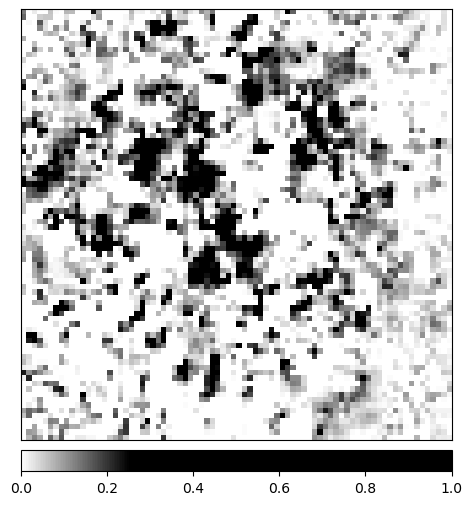

In [60]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

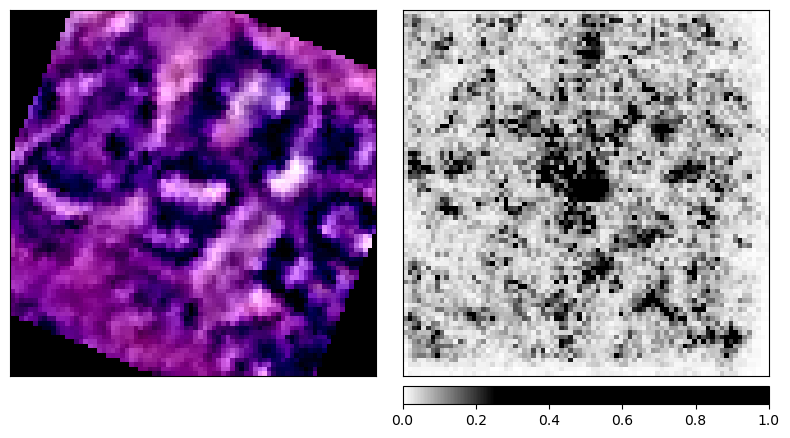

In [61]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input_image, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Occlusion Based Attribution

Using the sliding window for occlusion based attribution shows that the bottom right of the image was dominant in the classifiers decision making process. It is difficult to interpret why this is because in the original transformed image, the area does not look particularly unique. 

In [62]:
occlusion = Occlusion(opt_model)

attributions_occ = occlusion.attribute(input_image,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

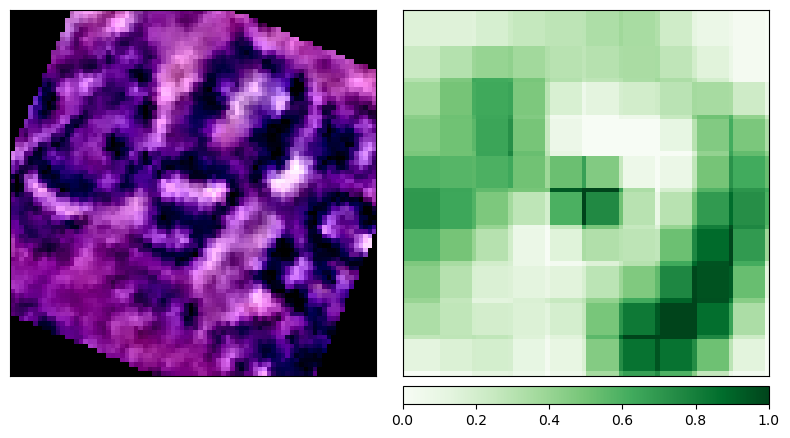

In [63]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## Submission to CSV

In [54]:
submission_df2 = output_loop(model=model2, device=device, test_loader=test_loader)
submission_df2


,Filename,Label
0,14127.png,0
1,11396.png,0
2,14260.png,1
3,12329.png,1
4,13412.png,1
...,...,...
5036,13785.png,1
5037,13283.png,3
5038,14735.png,1
5039,12060.png,2


In [55]:
submission_df2.to_csv('/kaggle/working/submission.csv',index=False)

## Conclusion

Comparing both models, Model 2 classified images more accurately and with lower average loss across validation testing. Pretraining over ImageNet undoubtedly enabled the model to perform better than the custom CNN that I created. Ray tune was used for hyperparameter tuning for both models, but unfortunately was not as utilized very effectively by me since I was able to create more accurate models through mostly trial and error, and examining loss/accuracy curves and confusion matrices. Captum confirmed that the most important area for both models was generally right in the center nuclei of the images. 